In [165]:
import pandas as pd
import numpy as np
import pickle
import itertools
from random import shuffle

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [166]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [167]:
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

In [168]:
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib import rcParams

In [169]:
def mean_squared_error(grp):
    return np.mean((grp.costs - grp.costs.mean())**2)

In [170]:
df = pickle.load(open('categorical_meps_2015.pkl', 'rb'))
df.head()

,ER_exp,age,dx_COPD,dx_IHD,dx_arth,dx_asth,dx_canc,dx_diab,dx_hyplp,dx_hyptn,...,tot_prv_exp,tot_slf_exp,user_id,tot_exp_cats,tot_slf_cats,tot_mcr_cats,tot_mcd_cats,tot_prv_cats,age_cat,exp_deciles
0,772,53,Yes,Yes,Yes,No,No,Yes,Yes,Yes,...,0,375,60001101,$4033-$700771,$228-$692,$7803-$421571,$1560-$534580,$0,45-64,"(9768.0, 700771.0]"
1,362,56,No,No,Yes,Yes,No,Yes,Yes,Yes,...,0,11,60001102,$4033-$700771,$1-$63,$2168-$7802,$1560-$534580,$0,45-64,"(4068.0, 9768.0]"
2,0,30,No,No,No,No,No,No,No,No,...,0,0,60001103,$0,$0,$0,$0,$0,25-44,"(-0.001, 12.0]"
3,381,23,No,No,No,No,No,No,No,No,...,0,22,60001104,$332-$1098,$1-$63,$0,$433-$1559,$0,18-24,"(620.0, 1111.0]"
4,0,3,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,...,0,77,60001105,$1099-$4032,$63-$227,$0,$1560-$534580,$0,0-4,"(2045.0, 4068.0]"


In [171]:
# Convert "Inapplicable" Diagnosis responses (i.e. responses for those under 17 y/o) to "No"
chron_dx_categs = ['dx_arth', 'dx_asth', 'dx_canc', 'dx_COPD', 'dx_diab', 'dx_hyplp', 'dx_hyptn', 'dx_IHD', 'dx_strk']
dx_fillna_map = {dx: 'No' for dx in chron_dx_categs}
df_no_nulls = df.dropna(subset=(['age', 'age_cat', 'sex', 'tot_exp', 'rh31', 'mh31'])).fillna(value=dx_fillna_map)

In [172]:
# Convert relevant categorical variables to numerical
df = df_no_nulls
# Sex
df['female'] = [x=='female' for x in df.sex]

# Diagnosis
for dx in chron_dx_categs:
    df['{}'.format(dx)] = [x=='Yes' for x in df['{}'.format(dx)]]

# Self-Health Rating
def rate_to_code(rating):
    if rating=='Excellent':
        return 1 
    elif rating=='Very Good':
        return 2
    elif rating=='Good':
        return 3
    elif rating=='Fair':
        return 4
    elif rating=='Poor':
        return 5

health_rating_series = ['rh31', 'mh31']
for categ in health_rating_series:
    df['{}'.format(categ)] = [rate_to_code(x) for x in df['{}'.format(categ)]]

In [173]:
age_cats = pd.cut(df['age'], bins=[0, 4, 17, 24, 44, 64, 85], labels=[0, 4, 17, 24, 44, 64], right=True)
df['age_cat'] = age_cats

## Stats at a Glance Graphs (Used for Presentation)

17774
16422


(-1.1096732340946136,
 1.1004606800986931,
 -1.1148810874652857,
 1.10756714955349)

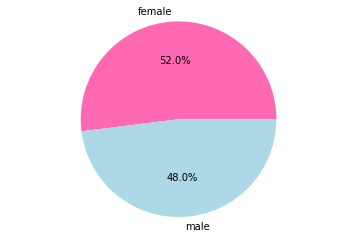

In [174]:
# Plot Sex
female_num = len(df[df.female])
print female_num
male_num = len(df) - female_num
print male_num
plt.pie([female_num, male_num], colors=['hotpink', 'lightblue'], autopct='%1.1f%%', labels=['female', 'male'])
plt.axis('equal')

[Text(0,0,u'0-4'),
 Text(0,0,u'5-17'),
 Text(0,0,u'18-24'),
 Text(0,0,u'25-44'),
 Text(0,0,u'45-64'),
 Text(0,0,u'65-85')]

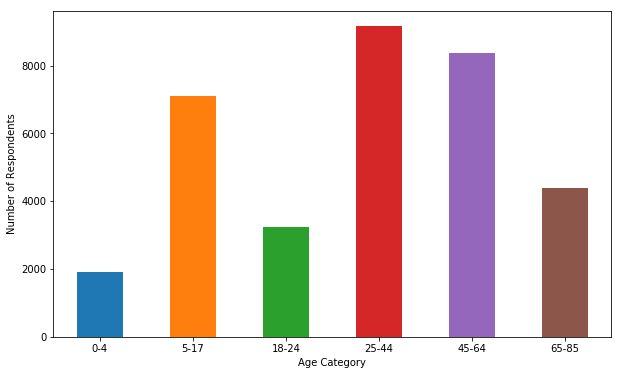

In [175]:
# Plot age_cats
df.age_cat.value_counts().sort_index().plot.bar(rot=0, figsize=(10,6))

ax=plt.gca()
ax.set_xlabel('Age Category'), ax.set_ylabel('Number of Respondents')
ax.set_xticklabels(['0-4','5-17', '18-24', '25-44', '45-64', '65-85'])

In [176]:
# Avg Number of Diagnoses
df[chron_dx_categs].apply(pd.value_counts).sum(axis=1)
33086 / len(df)

0.9675400631652825

In [177]:
# Pct of Respondents with each diagnosis
df_dx_resp = df[chron_dx_categs].apply(pd.value_counts).transpose()
#df_dx_resp['pct'] = df_dx_resp['True'] / df_dx_resp['False']
df_dx_resp

,False,True
dx_arth,27932,6264
dx_asth,30805,3391
dx_canc,31987,2209
dx_COPD,33735,461
dx_diab,31449,2747
dx_hyplp,26822,7374
dx_hyptn,25856,8340
dx_IHD,32923,1273
dx_strk,33169,1027


In [178]:
# Avg Self-assessed health
df.rh31.mean()

2.192741841151012

Text(0.5,0,u'Total Expenditures ($)')

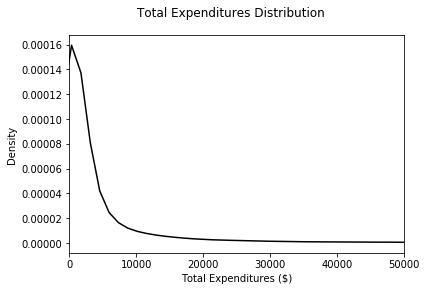

In [179]:
# Mean expenditures
df.tot_exp.plot.kde(xlim=(0,50000), color='black')
plt.suptitle('Total Expenditures Distribution')
plt.xlabel('Total Expenditures ($)')

In [242]:
df.groupby('rh31')['tot_exp'].describe()[['mean','min','max','25%','50%','75%', 'std']].rename(index={1: 'Excellent', 2:'Very Good', 3: 'Good', 4:'Fair', 5:'Poor'})

,mean,min,max,25%,50%,75%,std
rh31,,,,,,,
Excellent,1755.378458,0.0,214830.0,38.00,340.0,1250.00,5930.054395
Very Good,3148.054024,0.0,222188.0,108.00,641.0,2528.00,8674.867119
Good,4946.163130,0.0,608264.0,127.00,918.0,4141.00,14425.816063
Fair,9844.561758,0.0,659952.0,507.75,2442.0,9594.75,23389.033615
Poor,19341.397590,0.0,700771.0,1855.00,7090.5,21255.50,41457.946461


## Train and Test Data

In [181]:
# Split into testing and training data
train_ix, test_ix = train_test_split(df.index, test_size=.2)

train_ix

Int64Index([24886, 15986, 34998, 11732, 28897,  8525,  1991, 18467, 17704,
            24511,
            ...
            10582, 32254,  3129, 20717,  6155, 25659, 22078,  5036, 29680,
            25754],
           dtype='int64', length=27356)

In [182]:
df = df[(['age', 'age_cat', 'female', 'tot_exp'] + chron_dx_categs + health_rating_series)]

In [183]:
df.head()

,age,age_cat,female,tot_exp,dx_arth,dx_asth,dx_canc,dx_COPD,dx_diab,dx_hyplp,dx_hyptn,dx_IHD,dx_strk,rh31,mh31
0,53,44,False,46612,True,False,False,True,True,True,True,True,False,4,1
1,56,44,True,9207,True,True,False,False,True,True,True,False,False,4,1
2,30,24,False,0,False,False,False,False,False,False,False,False,False,1,1
3,23,17,True,808,False,False,False,False,False,False,False,False,False,1,1
4,3,0,False,2721,False,False,False,False,False,False,False,False,False,1,1


In [184]:
# Generate testing and training datasets
train_df = df.loc[train_ix]
test_df = df.loc[test_ix]

## Collect Classification Model Data

In [185]:
# Necessary lists for helper function
model_variants = [(['age_cat', 'female'] + chron_dx_categs), (['age_cat', 'female', 'rh31'] + chron_dx_categs)]
model_variant_names = ['age_sex_dx', 'age_sex_dx_rh']
health_rating_cats = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']
subgroup_test_cats = ['test_e', 'test_vg', 'test_g', 'test_f', 'test_p']

In [186]:
# Data Structures to hold data
train_test_analysis = {}
tta = train_test_analysis
mean_errors = {}

# Helper function to calculate mean errors
def mean_err(s1, s2):
    return (s1 - s2).mean()

mean_real_vals = {}
mrv = mean_real_vals

In [254]:
# Helper function to collect data for Regression Model
def train_test_data(train_set, test_set):
    for variant, name in itertools.izip(model_variants, model_variant_names):
        print "Training and Testing on {}".format(name)
        print variant
        print name
        # Train Data
        regr = RandomForestRegressor(min_samples_leaf=100, 
                                     max_features=.9, n_estimators=20).fit(train_set[variant], train_set['tot_exp'])
            
        tta['{}'.format(name)] = {}
        
        # Collect Variant Type
        tta.get('{}'.format(name))['variant'] = variant
        
        
        # Collect Feature Importances
        tta.get('{}'.format(name))['feature_imp'] = regr.feature_importances_
        
        # Collect, Print Training Values (full training set)
        predicted_exp = regr.predict(train_set[variant])
        real_exp = train_set['tot_exp']
        
        
        tta.get('{}'.format(name))['train_r2'] = r2_score(real_exp, predicted_exp)
        tta.get('{}'.format(name))['train_mae'] = mean_absolute_error(real_exp, predicted_exp)
        
        # Collect, Print Test Values (full test set)
        predicted_exp = regr.predict(test_set[variant])
        real_exp = test_set['tot_exp']
        
        # Save MAE, R2, and ME
        tta.get('{}'.format(name))['test_r2_all'] = r2_score(real_exp, predicted_exp)
        tta.get('{}'.format(name))['test_mae_all'] = mean_absolute_error(real_exp, predicted_exp)
        mean_errors['{}'.format(name)] = {'test_all': mean_err(real_exp, predicted_exp)}
        
        # Collect, Print Test Values (subgroups - self-assessed health)
        for rate_name, subgroup_name in itertools.izip(health_rating_cats, subgroup_test_cats):
            rating = rate_to_code(rate_name)
            test_subset = test_set[test_set.rh31==rating]
            
            predicted_exp = regr.predict(test_subset[variant])
            real_exp = test_subset['tot_exp']
            
            MAE = mean_absolute_error(real_exp, predicted_exp)
            ME = mean_err(real_exp, predicted_exp)
            
            # Save MAE, R2, and ME
            tta.get('{}'.format(name))['{}'.format(subgroup_name)] = MAE
            tta.get('{}'.format(name))['test_r2_{}'.format(subgroup_name)] = r2_score(real_exp, predicted_exp)
            mean_errors.get('{}'.format(name))['{}'.format(subgroup_name)] = ME
            
        
        # Collect, Print Test Values (subgroups - diagnosis category)
        for dx in chron_dx_categs:
            test_subset = test_set[test_set['{}'.format(dx)]==True]
            
            predicted_exp = regr.predict(test_subset[variant])
            real_exp = test_subset['tot_exp']
            
            MAE = mean_absolute_error(real_exp, predicted_exp)
            ME = mean_err(real_exp, predicted_exp)

            
            tta.get('{}'.format(name))['{}'.format('test_{}'.format(dx))] = MAE
            tta.get('{}'.format(name))['test_r2_{}'.format(dx)] = r2_score(real_exp, predicted_exp)
            mean_errors.get('{}'.format(name))['{}'.format('test_{}'.format(dx))] = ME
        
        print '\n', '\n'

In [255]:
# Function call to train/test data
train_test_data(train_df, test_df)

Training and Testing on age_sex_dx
['age_cat', 'female', 'dx_diab', 'dx_asth', 'dx_canc', 'dx_COPD', 'dx_strk', 'dx_arth', 'dx_IHD', 'dx_hyptn', 'dx_hyplp']
age_sex_dx



Training and Testing on age_sex_dx_rh
['age_cat', 'female', 'rh31', 'dx_diab', 'dx_asth', 'dx_canc', 'dx_COPD', 'dx_strk', 'dx_arth', 'dx_IHD', 'dx_hyptn', 'dx_hyplp']
age_sex_dx_rh





In [256]:
# Prepare Data as DataFrame
tta_df = pd.DataFrame(tta)
tta_df

,age_sex_dx,age_sex_dx_rh
feature_imp,"[0.03446651551657513, 0.0193535196142633, 0.06...","[0.039447310671229384, 0.014586631149944494, 0..."
test_dx_COPD,10806.1,10939.1
test_dx_IHD,15521.7,15023.7
test_dx_arth,10190.7,9968.08
test_dx_asth,6183.47,5975.05
test_dx_canc,11689.6,11275.6
test_dx_diab,11678.9,11267.1
test_dx_hyplp,8593.77,8421.61
test_dx_hyptn,8740.72,8549.9
test_dx_strk,16154.1,14432.9


In [258]:
# Filter for overall goodness-of-fit values
tta_df.loc[['test_r2_all', 'test_mae_all']]

,age_sex_dx,age_sex_dx_rh
test_r2_all,0.103123,0.120468
test_mae_all,4560.04,4483.31


## Plot density curves by Model Variant

Text(0.5,1,u'Real Expenditures by Self-Health Rating')

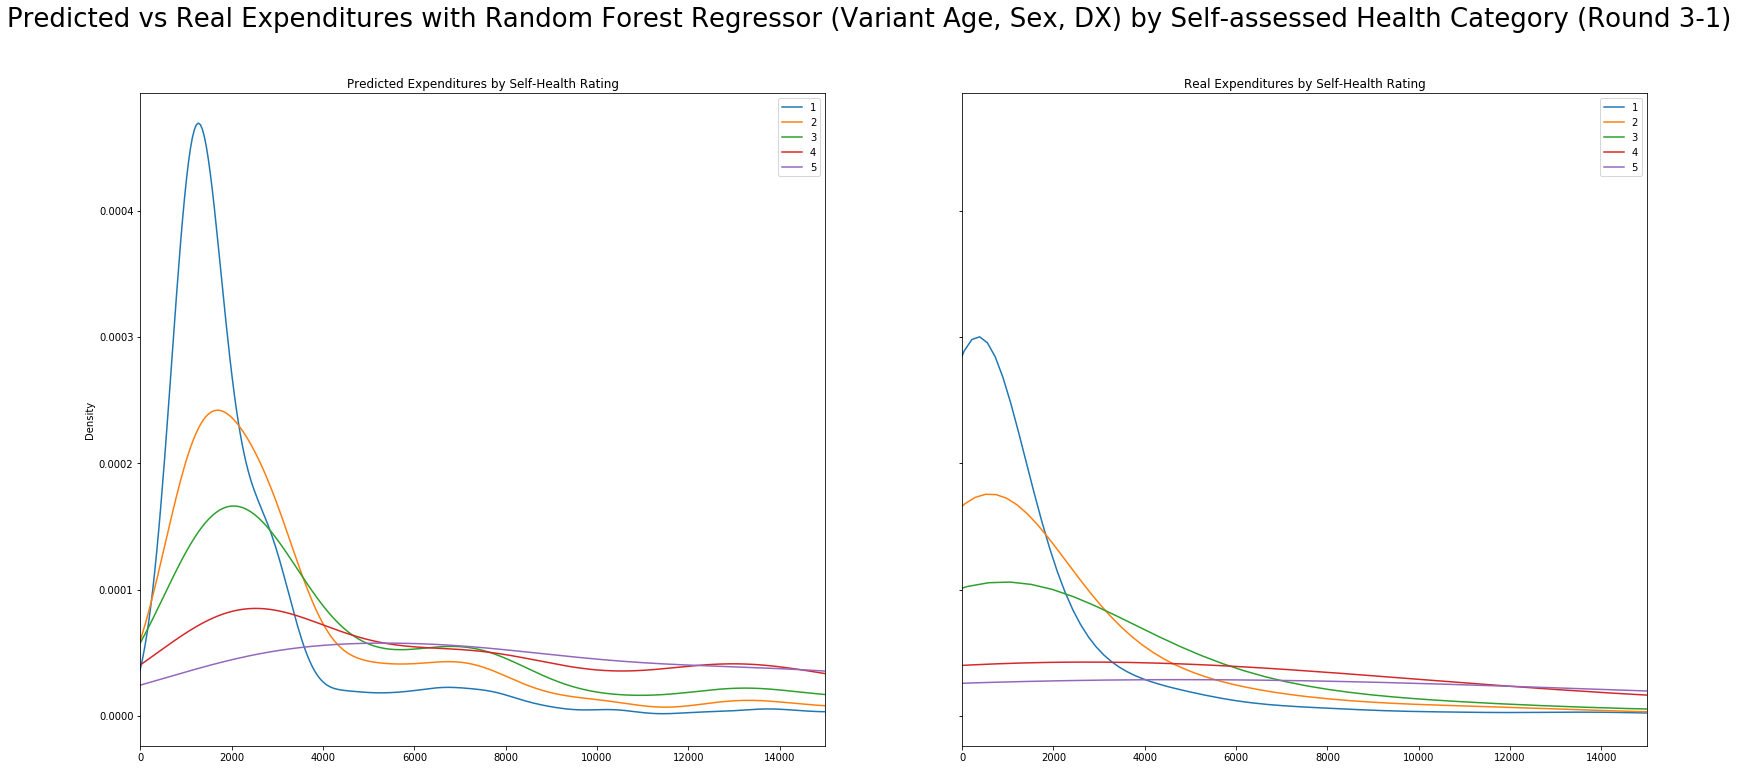

In [261]:
# Density Curves by self-reported health for Base Model
# Plot Density Curves for Model Variant with age, sex, dx, RH
regr = RandomForestRegressor(min_samples_leaf=100, max_features=.9).fit(train_df[model_variants[0]], train_df['tot_exp'])

# Predict on test set
predicted_exp = regr.predict(test_df[model_variants[0]])
test_df['predicted_exp_mv0'] = predicted_exp

fig, axs = plt.subplots(1, 2, figsize=(27,12), sharey=True)
plt.suptitle('Predicted vs Real Expenditures with Random Forest Regressor (Variant Age, Sex, DX) by Self-assessed Health Category (Round 3-1)', fontsize=26)
test_df.groupby('rh31')['predicted_exp_mv0'].plot(kind='kde', legend=True, xlim=(0,15000), ax=axs[0])
axs[0].set_title('Predicted Expenditures by Self-Health Rating')
test_df.groupby('rh31')['tot_exp'].plot(kind='kde', legend=True, xlim=(0,15000), ax=axs[1])
axs[1].set_title('Real Expenditures by Self-Health Rating')

In [265]:
# Plot Density Curves for Model Variant with age, sex, dx, RH
regr = RandomForestRegressor(min_samples_leaf=100, max_features=.9).fit(train_df[model_variants[1]], train_df['tot_exp'])

# Predict on test set
predicted_exp = regr.predict(test_df[model_variants[1]])
test_df['predicted_exp_mv4'] = predicted_exp

Text(0.5,1,u'Real Expenditures by Self-Health Rating')

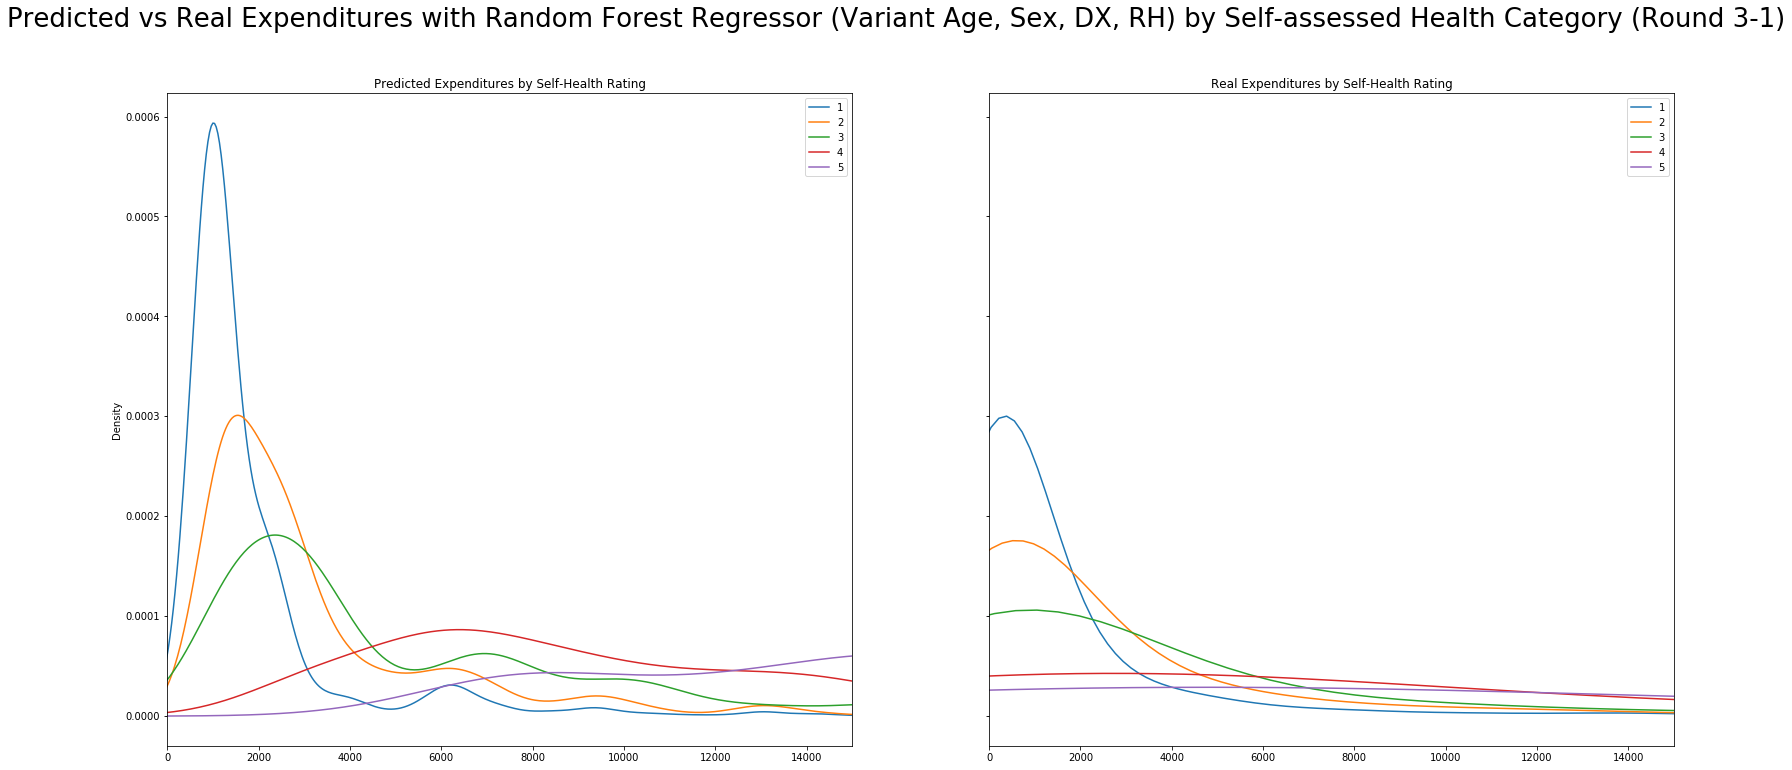

In [266]:
fig, axs = plt.subplots(1, 2, figsize=(27,12), sharey=True)
plt.suptitle('Predicted vs Real Expenditures with Random Forest Regressor (Variant Age, Sex, DX, RH) by Self-assessed Health Category (Round 3-1)', fontsize=26)

test_df.groupby('rh31')['predicted_exp_mv4'].plot(kind='kde', legend=True, xlim=(0,15000), ax=axs[0])
axs[0].set_title('Predicted Expenditures by Self-Health Rating')
test_df.groupby('rh31')['tot_exp'].plot(kind='kde', legend=True, xlim=(0,15000), ax=axs[1])
axs[1].set_title('Real Expenditures by Self-Health Rating')

In [196]:
# Prepare dataset to analyze mean abs error by diagnosis
tta_by_cat_no_r2 = tta_by_cat.drop(['test_r2_all','train_r2', 'train_mae'])
tta_by_cat_no_r2 = tta_by_cat_no_r2.reindex(index=['test_mae_all','test_e','test_vg','test_g','test_f','test_p'])
tta_by_cat_no_r2

,age_sex_dx,age_sex_dx_rh
test_mae_all,4564.25,4496.67
test_e,2314.92,1987.53
test_vg,3551.81,3262.63
test_g,5518.91,5426.78
test_f,10272.4,11130.2
test_p,13439.8,15648.4


Text(0.5,0,u'Test Category')

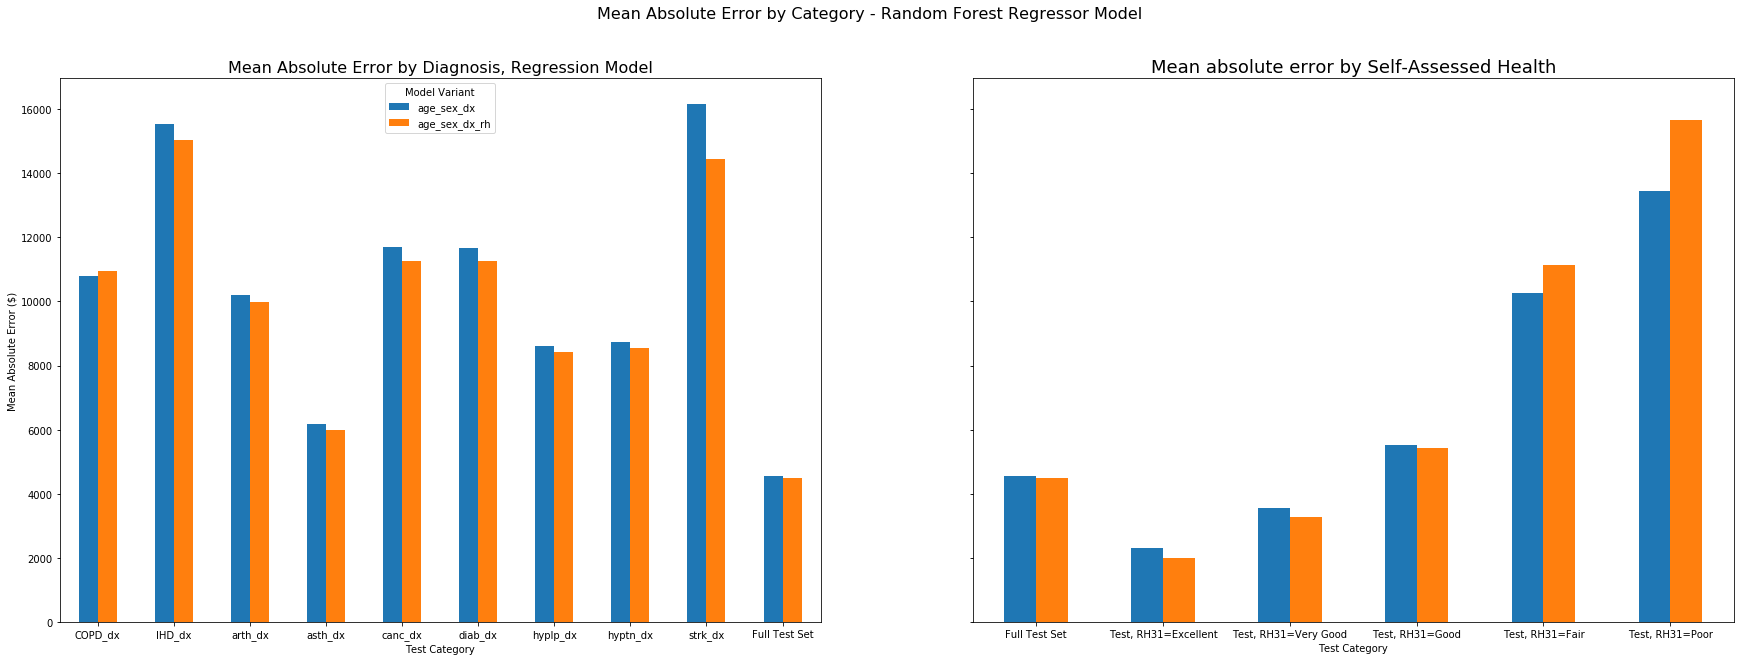

In [267]:
# Mean absolute error by diagnosis
tta_dx = pd.DataFrame(tta).loc[['test_dx_COPD', 'test_dx_IHD', 'test_dx_arth', 'test_dx_asth', 'test_dx_canc', 'test_dx_diab',
                         'test_dx_hyplp', 'test_dx_hyptn', 'test_dx_strk', 'test_mae_all']]

fig, axs = plt.subplots(1, 2, figsize=(30,10), sharey=True)
axs[0].legend(labels=('Age & Sex','Age, Sex & DX_cats','Age, Sex, DX_cats & MH31','Age, Sex, DX_cats & RH31','Age, Sex, DX_cats, RH31 and MH31'), title='Model Variant' )

plt.suptitle('Mean Absolute Error by Category - Random Forest Regressor Model', fontsize=16)


tta_dx[['age_sex_dx', 'age_sex_dx_rh']].plot.bar(rot=0, ax=axs[0])
axs[0].set_xticklabels(('COPD_dx', 'IHD_dx', 'arth_dx', 'asth_dx', 'canc_dx', 'diab_dx', 'hyplp_dx', 'hyptn_dx', 'strk_dx', 'Full Test Set'))
axs[0].set_xlabel('Test Category'), axs[0].set_ylabel('Mean Absolute Error ($)')
axs[0].set_title('Mean Absolute Error by Diagnosis, Regression Model', fontsize=16)

tta_by_cat_no_r2[['age_sex_dx', 'age_sex_dx_rh']].plot.bar(rot=0, ax=axs[1], legend=False)
axs[1].set_ylabel('Mean absolute error ($)'), ax.set_xlabel('Testing/Training Category')
axs[1].set_title('Mean absolute error by Self-Assessed Health', fontsize=18)
axs[1].set_xticklabels( ('Full Test Set', 'Test, RH31=Excellent', 'Test, RH31=Very Good', 'Test, RH31=Good', 'Test, RH31=Fair', 'Test, RH31=Poor'))
axs[1].set_xlabel('Test Category')



Text(0.5,1,u'Change in Mean Absolute Error by Self-Assessed Health')

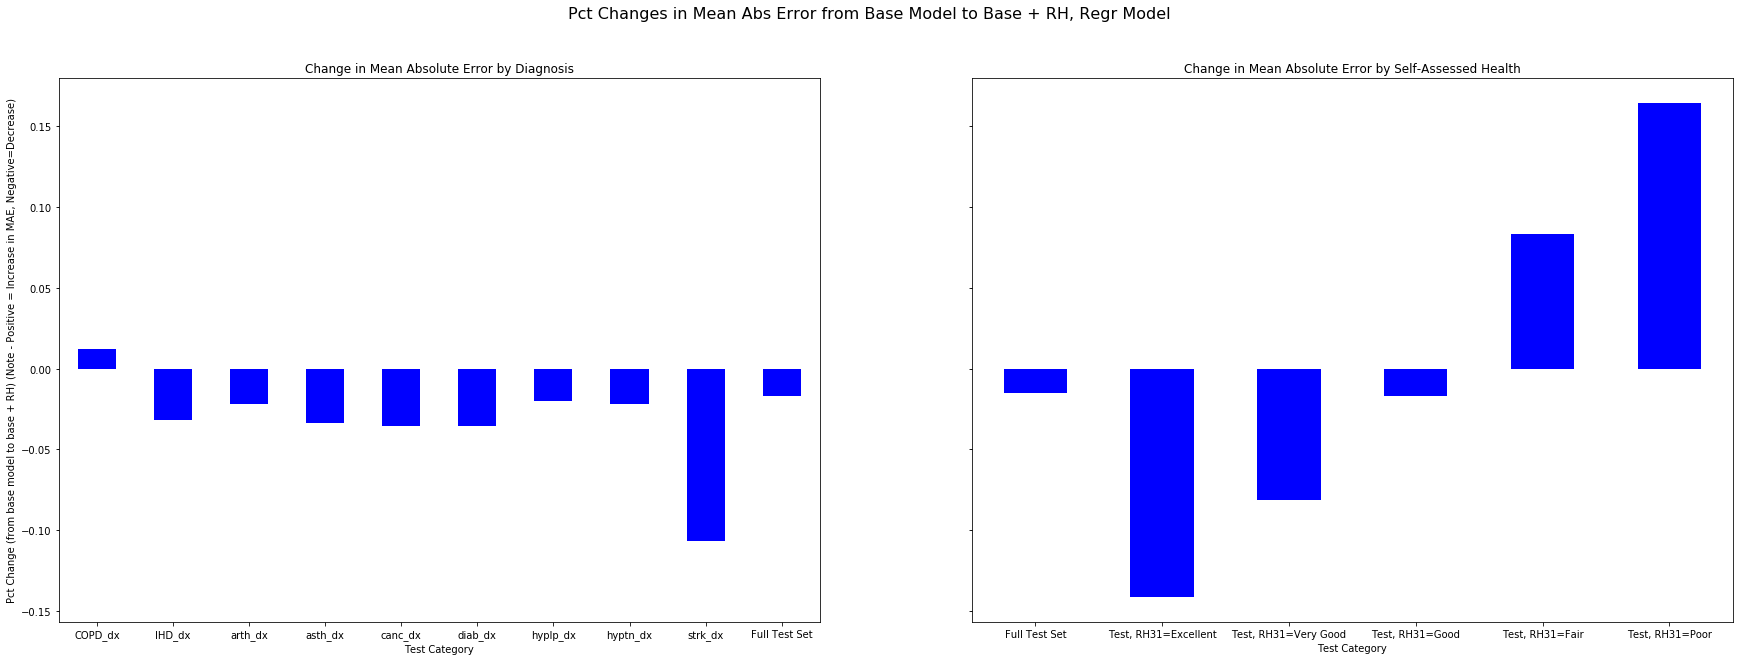

In [269]:
# Pct Changes in Mean Absolute Error by Category
fig, axs = plt.subplots(1, 2, figsize=(30,10), sharey=True)

plt.suptitle('Pct Changes in Mean Abs Error from Base Model to Base + RH, Regr Model', fontsize=16)

# Changes in Mean Absolute Error by diagnosis
tta_dx['pct_change'] = (tta_dx['age_sex_dx_rh']/tta_dx['age_sex_dx'] - 1)
tta_dx['pct_change'].plot.bar(ax=axs[0], rot=0, color='blue')
axs[0].set_ylabel('Pct Change (from base model to base + RH) (Note - Positive = Increase in MAE, Negative=Decrease)')
axs[0].set_xticklabels(('COPD_dx', 'IHD_dx', 'arth_dx', 'asth_dx', 'canc_dx', 'diab_dx', 'hyplp_dx', 'hyptn_dx', 'strk_dx', 'Full Test Set'))
axs[0].set_xlabel('Test Category')
axs[0].set_title('Change in Mean Absolute Error by Diagnosis')

# Changes in Mean Absolute Error by self-assessed health
tta_by_cat_no_r2['pct_change'] = (tta_by_cat_no_r2['age_sex_dx_rh']/tta_by_cat_no_r2['age_sex_dx'] - 1)
tta_by_cat_no_r2['pct_change'].plot.bar(ax=axs[1], rot=0, colors=['blue'])
axs[1].set_xticklabels( ('Full Test Set', 'Test, RH31=Excellent', 'Test, RH31=Very Good', 'Test, RH31=Good', 'Test, RH31=Fair', 'Test, RH31=Poor'))
axs[1].set_xlabel('Test Category')
axs[1].set_title('Change in Mean Absolute Error by Self-Assessed Health')


In [199]:
# Mean Error by Diagnosis Category - Prepare Data
# Note - positive = underprediction, negative = overprediction
mean_err_df = pd.DataFrame(mean_errors)
mean_err_dx_df = pd.DataFrame(mean_err_df).loc[['test_dx_COPD', 'test_dx_IHD', 'test_dx_arth', 'test_dx_asth', 'test_dx_canc', 'test_dx_diab',
                                                 'test_dx_hyplp', 'test_dx_hyptn', 'test_dx_strk', 'test_all']]
mean_err_dx_df

,age_sex_dx,age_sex_dx_rh
test_dx_COPD,1418.230904,749.233088
test_dx_IHD,-2382.538919,-1093.035929
test_dx_arth,-954.359874,-965.521051
test_dx_asth,653.041985,779.830591
test_dx_canc,-754.140313,400.185352
test_dx_diab,-40.989839,73.246778
test_dx_hyplp,-690.563546,-545.770416
test_dx_hyptn,-1275.404186,-1051.790676
test_dx_strk,-228.602899,100.408375
test_all,-167.221341,-166.472809


Text(0.5,1,u'Mean error by Diagnosis Category, Regr Model')

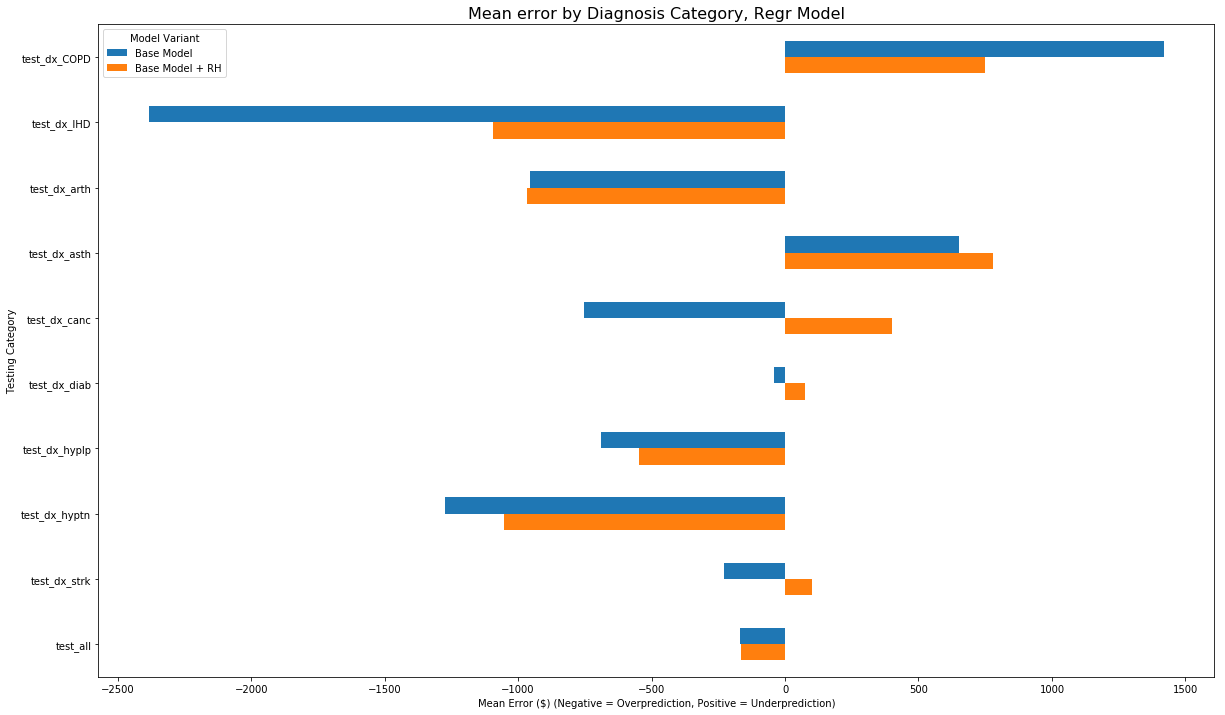

In [284]:
# Mean Error by Diagnosis Category - Graph Data
mean_err_dx_df[['age_sex_dx', 'age_sex_dx_rh']].plot.barh(figsize=(20,12))

ax=plt.gca()
ax.invert_yaxis()
ax.legend(('Base Model','Base Model + RH'), title='Model Variant')
ax.set_ylabel('Testing Category'), ax.set_xlabel('Mean Error ($) (Negative = Overprediction, Positive = Underprediction)')
ax.set_title('Mean error by Diagnosis Category, Regr Model', fontsize=16)

Text(0.5,1,u'Overall R2 Test values by Model Variant, Regr Model')

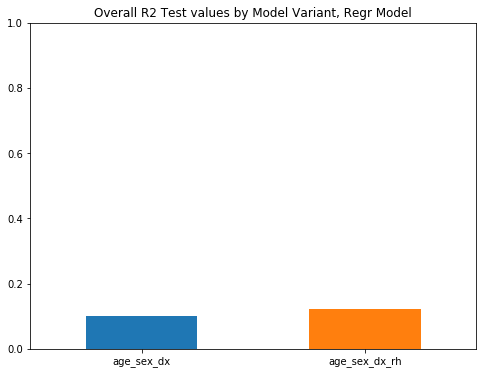

In [202]:
test_r2_df.plot.bar(rot=0, figsize=(8,6))

ax = plt.gca()

ax.set_ylim(0,1)
ax.set_title('Overall R2 Test values by Model Variant, Regr Model')
#ax.set_xlabel()

In [203]:
# R2 Test Values by subgroup & model variant
tta_df = pd.DataFrame(tta)
tta_df
tta_index_lst = list(tta_df.index.values)
tta_r2_lst = filter(lambda x: x.startswith('test_r2'), tta_index_lst)
tta_r2_df = tta_df.loc[tta_r2_lst]
tta_r2_df

,age_sex_dx,age_sex_dx_rh
test_r2_all,0.100501,0.121607
test_r2_dx_COPD,0.0652235,0.103394
test_r2_dx_IHD,-3.34634e-05,0.0373129
test_r2_dx_arth,0.0493713,0.0799628
test_r2_dx_asth,0.0687687,0.107118
test_r2_dx_canc,0.0196496,0.0456071
test_r2_dx_diab,0.0191262,0.0460977
test_r2_dx_hyplp,0.0786645,0.105768
test_r2_dx_hyptn,0.0730651,0.0944983
test_r2_dx_strk,0.0121821,0.0546532


In [204]:
# Organize Data
# Note - positive = underprediction, negative = overprediction
mean_err_df = pd.DataFrame(mean_errors)
mean_err_df = mean_err_df.reindex(index=['test_all', 'test_e', 'test_vg', 'test_g', 'test_f', 'test_p'])
mean_err_df

,age_sex_dx,age_sex_dx_rh
test_all,-167.221341,-166.472809
test_e,-736.646495,-237.353754
test_vg,-840.724075,-332.939074
test_g,-448.368662,-221.554276
test_f,2740.732766,936.687364
test_p,5589.300148,-981.668088


Text(0.5,1,u'Mean error by Self-Assessed Health Category, Regr Model')

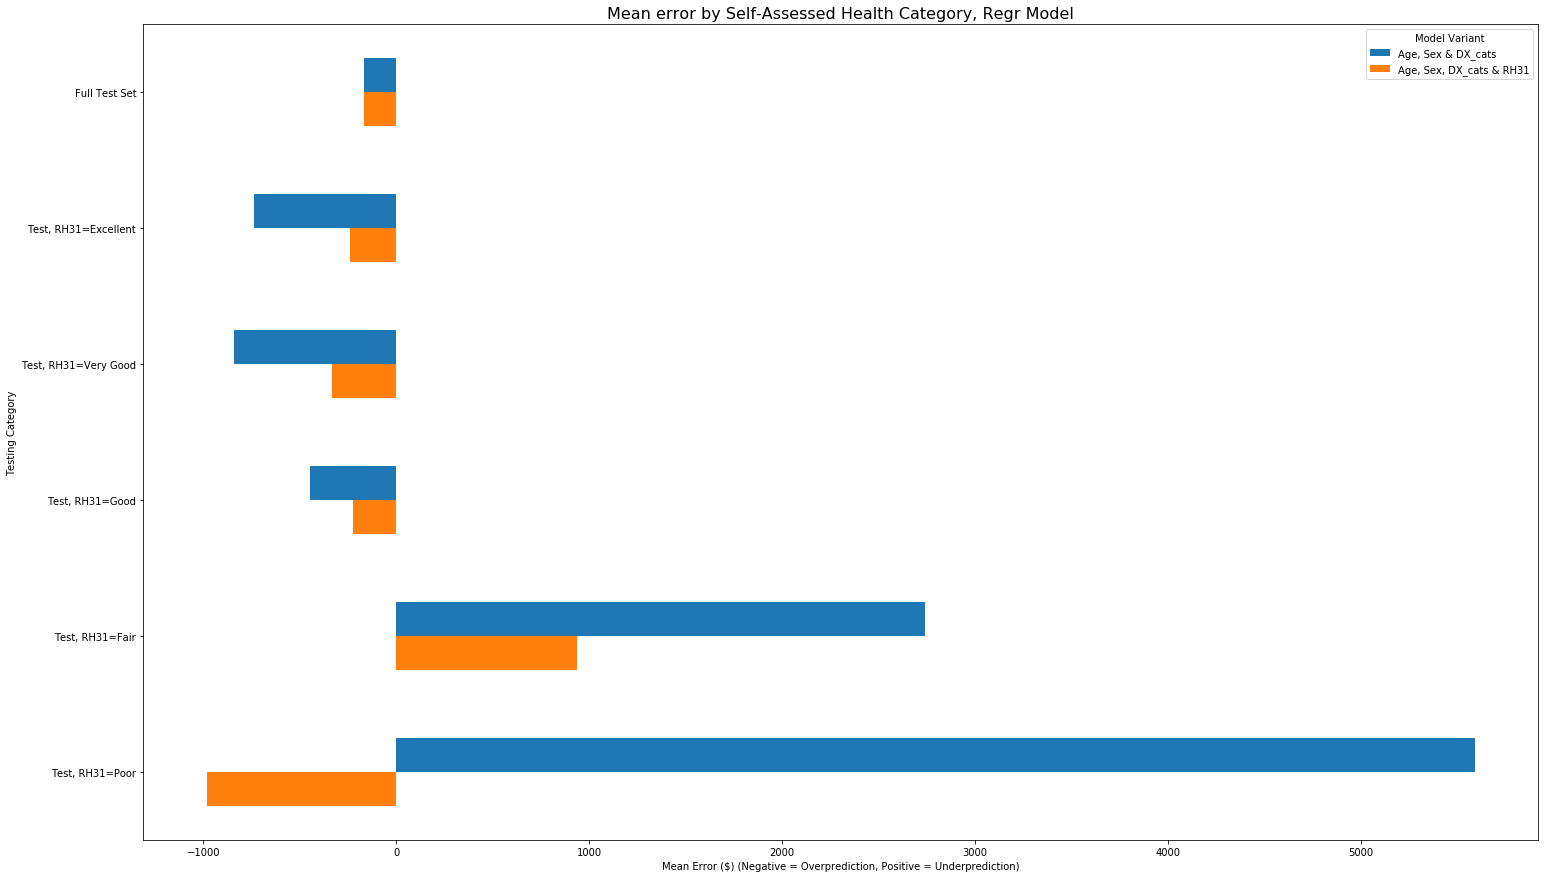

In [205]:
# Plot mean error by self-assessed health category
mean_err_df[['age_sex_dx', 'age_sex_dx_rh']].plot.barh(figsize=(25,15))

ax=plt.gca()
ax.invert_yaxis()
ax.set_yticklabels(('Full Test Set', 'Test, RH31=Excellent', 'Test, RH31=Very Good', 'Test, RH31=Good', 'Test, RH31=Fair', 'Test, RH31=Poor'))
ax.legend(('Age, Sex & DX_cats','Age, Sex, DX_cats & RH31'), title='Model Variant')
ax.set_ylabel('Testing Category'), ax.set_xlabel('Mean Error ($) (Negative = Overprediction, Positive = Underprediction)')
ax.set_title('Mean error by Self-Assessed Health Category, Regr Model', fontsize=16)

# Random Forest Classifier

In [270]:
# Define Data Structures to hold data for Classifier analysis
train_classify_analysis = {}
tca = train_classify_analysis

In [271]:
# Binary Percentile Calculator Helper function
def top_percentile_calculator(dataset, percentile):
    ser, bins = pd.qcut(dataset, percentile, duplicates='drop', retbins=True)
    top_quantile_s = bins[-2] 
    top_quantile_e = bins[-1]
    return (np.array(dataset.between(top_quantile_s, top_quantile_e, inclusive=True))), top_quantile_s, top_quantile_e

In [208]:
# Calculate true range for top percentile of full dataset
_, full_top_10_s, full_top_10_e = top_percentile_calculator(df['tot_exp'], 10)
print full_top_10_s, full_top_10_e

9964.5 700771.0


In [272]:
# Helper function to return mask for top percentile of given dataset
def top_percentile_subset_calculator(dataset, range_s, range_e):
    return (np.array(dataset.between(range_s, range_e, inclusive=True)))

In [273]:
real_exp = train_df['tot_exp']
real_exp_class = top_percentile_calculator(real_exp, 10)
real_exp_class

(array([ True, False, False, ..., False, False, False]), 10022.0, 700771.0)

In [274]:
top_percentile_calculator(train_df['tot_exp'], 10)

(array([ True, False, False, ..., False, False, False]), 10022.0, 700771.0)

In [276]:
# Helper function to collect data for Classification analysis
def train_classify_data(train_set, test_set):
    for variant, name in itertools.izip(model_variants, model_variant_names):
        print "Training and Classifying on {}".format(name)
        
        # Train Model on values in training set that are in top 10% of full dataset
        real_exp = train_set['tot_exp']
        real_exp_class = top_percentile_subset_calculator(train_set.tot_exp, full_top_10_s, full_top_10_e)
        
        clf = RandomForestClassifier(min_samples_leaf=5, n_estimators=20).fit(train_set[variant], real_exp_class)
        tca['{}'.format(name)] = {}
        
        # Save Variant
        tca.get('{}'.format(name))['variant'] = variant
        
        # Collect Feature Importances
        print clf.feature_importances_
        tca.get('{}'.format(name))['feature_imp'] = clf.feature_importances_
        
        # Collect, Print Training Values (full training set)
        predicted_exp = clf.predict(train_set[variant])
        
        tca.get('{}'.format(name))['train_r2'] = r2_score(real_exp, predicted_exp)
        tca.get('{}'.format(name))['train_mae'] = mean_absolute_error(real_exp, predicted_exp)
        
        # Collect and Save Auc (training set)
        fpr, tpr, thresholds = roc_curve(real_exp_class, predicted_exp)
        tca.get('{}'.format(name))['train_auc_all'] = auc(fpr, tpr)
        
        # Collect, Print Test Values (full test set)
        predicted_exp = clf.predict(test_set[variant])
        real_exp = test_set['tot_exp']
        
        tca.get('{}'.format(name))['predicted_test'] = predicted_exp
        
        #predicted_exp_class = top_percentile_calculator(predicted_exp, P)
        real_exp_class = top_percentile_subset_calculator(real_exp, full_top_10_s, full_top_10_e)
        
        # Save MAE, R2, and ME
        tca.get('{}'.format(name))['test_r2_all'] = r2_score(real_exp, predicted_exp)
        tca.get('{}'.format(name))['test_mae_all'] = mean_absolute_error(real_exp, predicted_exp)
        tca.get('{}'.format(name))['test_me_all'] = mean_err(real_exp, predicted_exp)
        
         # Save AUC
        fpr, tpr, thresholds = roc_curve(real_exp_class, predicted_exp)
        tca.get('{}'.format(name))['test_auc_all'] = auc(fpr, tpr)
        
        # Collect, Print Test Values (subgroups - self-assessed health)
        for rate_name, subgroup_name in itertools.izip(health_rating_cats, subgroup_test_cats):
            rating = rate_to_code(rate_name)
            test_subset = test_set[test_set.rh31==rating]
            
            # Predict values for subset
            predicted_exp = clf.predict(test_subset[variant])
            real_exp = test_subset['tot_exp']
            
            #predicted_exp_class = top_percentile_calculator(predicted_exp, P)
            real_exp_class = top_percentile_subset_calculator(real_exp, full_top_10_s, full_top_10_e)
            
            # Save AUC
            fpr, tpr, thresholds = roc_curve(real_exp_class, predicted_exp)
            tca.get('{}'.format(name))['test_auc_{}'.format(subgroup_name)] = auc(fpr, tpr)
            
        
        # Collect, Print Test Values (subgroups - diagnosis category)
        for dx in chron_dx_categs:
            test_subset = test_set[test_set['{}'.format(dx)]==True]
            
            # Predict values for subset
            predicted_exp = clf.predict(test_subset[variant])
            real_exp = test_subset['tot_exp']
            
            real_exp_class = top_percentile_subset_calculator(real_exp, full_top_10_s, full_top_10_e)
            
            
            #Save AUC
            fpr, tpr, thresholds = roc_curve(real_exp_class, predicted_exp)
            tca.get('{}'.format(name))['test_auc_{}'.format(dx)] = auc(fpr, tpr)
        
        print '\n', '\n'

In [277]:
# Run function
train_classify_data(train_df, test_df)

Training and Classifying on age_sex_dx
[0.13893106 0.03642088 0.09411217 0.04210963 0.06872379 0.01830266
 0.05976676 0.2412405  0.10192414 0.14523563 0.05323277]



Training and Classifying on age_sex_dx_rh
[0.11968828 0.03911247 0.19411754 0.06653558 0.03426483 0.06083788
 0.01147603 0.04680025 0.21997686 0.06685253 0.07527635 0.0650614 ]





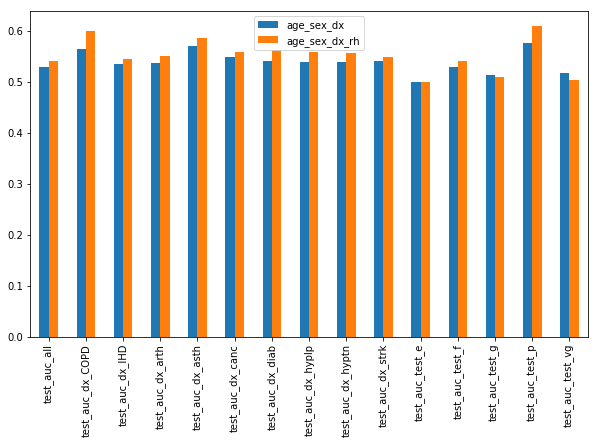

In [279]:
# Plot Area under the curve (AUCvalues by Diagnosis
tca_df = pd.DataFrame(tca)
tca_index_lst = list(tca_df.index.values)
tca_auc_lst = filter(lambda x: x.startswith('test_auc'), tca_index_lst)
tca_auc_df = tca_df.loc[tca_auc_lst]
tca_auc_df.plot.bar(figsize=(10,6))


In [281]:
from sklearn.metrics import confusion_matrix
real_exp = train_df['tot_exp']
real_exp_class = top_percentile_subset_calculator(train_df.tot_exp, full_top_10_s, full_top_10_e)

# Confusion matrix for full test set - Base Model
clf = RandomForestClassifier(min_samples_leaf=5, n_estimators=20).fit(train_df[model_variants[0]], real_exp_class)
predicted_exp = clf.predict(test_df[model_variants[0]])
real_exp = top_percentile_subset_calculator(test_df.tot_exp, full_top_10_s, full_top_10_e)
confusion_matrix(real_exp, predicted_exp)


array([[6110,   60],
       [ 621,   49]])

In [218]:
# Confusion matrix for full test set - Base Model + Rh
clf = RandomForestClassifier(min_samples_leaf=5, n_estimators=20).fit(train_df[model_variants[1]], real_exp_class)
predicted_exp = clf.predict(test_df[model_variants[1]])
real_exp = top_percentile_subset_calculator(test_df.tot_exp, full_top_10_s, full_top_10_e)
confusion_matrix(real_exp, predicted_exp)

array([[6094,   76],
       [ 601,   69]])

In [282]:
# Overall R2 and MAE for full test set
pd.DataFrame(tca).loc[['test_r2_all', 'test_mae_all']]

,age_sex_dx,age_sex_dx_rh
test_r2_all,-0.110248,-0.110247
test_mae_all,4100.32,4100.32


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,u'Change in Mean Absolute Error by Diagnosis, Classification Model')

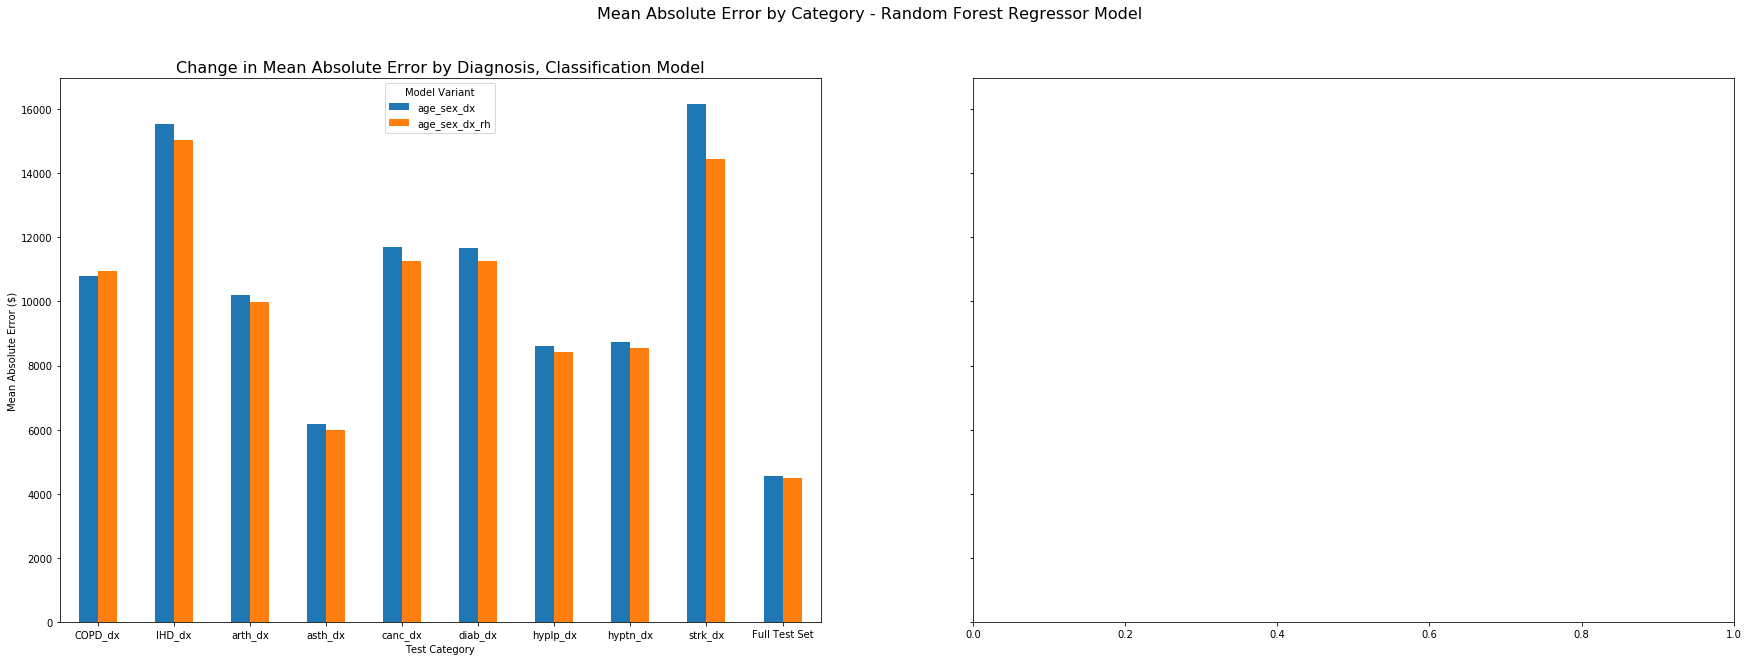

In [283]:
# Mean Absolute Error by Diagnosis for Classification Model
tca_dx_df = pd.DataFrame(tca).loc[['test_dx_COPD', 'test_dx_IHD', 'test_dx_arth', 'test_dx_asth', 'test_dx_canc', 'test_dx_diab',
                         'test_dx_hyplp', 'test_dx_hyptn', 'test_dx_strk', 'test_mae_all']]

fig, axs = plt.subplots(1, 2, figsize=(30,10), sharey=True)
axs[0].legend(labels=('Age & Sex','Age, Sex & DX_cats','Age, Sex, DX_cats & MH31','Age, Sex, DX_cats & RH31','Age, Sex, DX_cats, RH31 and MH31'), title='Model Variant' )

plt.suptitle('Mean Absolute Error by Category - Random Forest Regressor Model', fontsize=16)


tta_dx[['age_sex_dx', 'age_sex_dx_rh']].plot.bar(rot=0, ax=axs[0])
axs[0].set_xticklabels(('COPD_dx', 'IHD_dx', 'arth_dx', 'asth_dx', 'canc_dx', 'diab_dx', 'hyplp_dx', 'hyptn_dx', 'strk_dx', 'Full Test Set'))
axs[0].set_xlabel('Test Category'), axs[0].set_ylabel('Mean Absolute Error ($)')
axs[0].set_title('Change in Mean Absolute Error by Diagnosis, Classification Model', fontsize=16)

## Plot Feature Importance by Model

In [221]:
# Create DataFrame for Feature Importance (Regression Model)
feat_var_regr_df = tta_by_cat.loc[['feature_imp', 'variant']]
feat_var_regr_df

,age_sex_dx,age_sex_dx_rh
feature_imp,"[0.03534629692277917, 0.019015896989677962, 0....","[0.047310503609199306, 0.012031038770936722, 0..."
variant,"[age_cat, female, dx_diab, dx_asth, dx_canc, d...","[age_cat, female, rh31, dx_diab, dx_asth, dx_c..."


In [222]:
# Create DataFrame for Feature Importance (Classification Model)
feat_var_clf_df = pd.DataFrame(tca)[['age_sex_dx', 'age_sex_dx_rh']].loc[['feature_imp', 'variant']]
feat_var_clf_df

,age_sex_dx,age_sex_dx_rh
feature_imp,"[0.14827023818333648, 0.03844983877477846, 0.1...","[0.14315641175408736, 0.03728729564575789, 0.1..."
variant,"[age_cat, female, dx_diab, dx_asth, dx_canc, d...","[age_cat, female, rh31, dx_diab, dx_asth, dx_c..."


(Text(0,0.5,u'Feature Importance'), Text(0.5,0,u'Feature'))

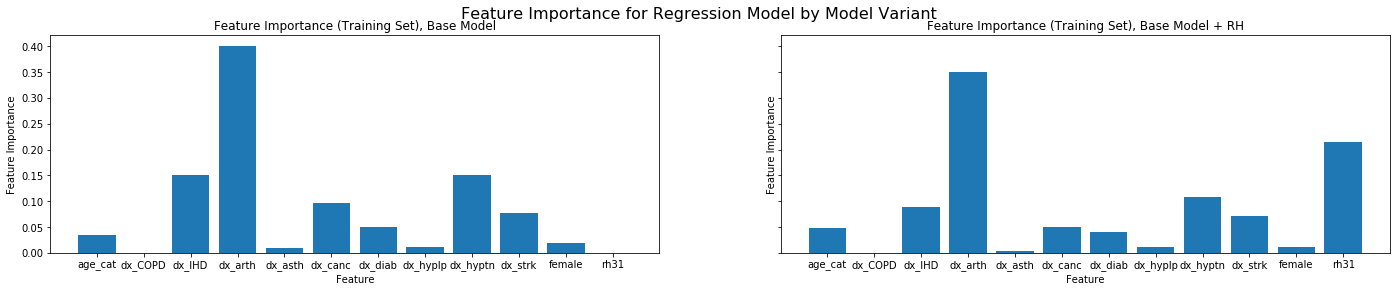

In [223]:
# Graph Feature Importance for both Base Models

# Graph Feature Importance for Regression Base Model
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,4), sharey=True, sharex=True)
plt.suptitle('Feature Importance for Regression Model by Model Variant', fontsize=16)

ax1.bar((feat_var_regr_df['age_sex_dx'].variant), (feat_var_regr_df['age_sex_dx'].feature_imp))
ax1.set_title('Feature Importance (Training Set), Base Model')
ax1.set_ylabel('Feature Importance'), ax1.set_xlabel('Feature')

# Graph Feature Importance for Classification Model
ax2.bar((feat_var_regr_df['age_sex_dx_rh'].variant), (feat_var_regr_df['age_sex_dx_rh'].feature_imp))
ax2.set_title('Feature Importance (Training Set), Base Model + RH')
ax2.set_ylabel('Feature Importance'), ax2.set_xlabel('Feature')


Text(0.5,0,u'Feature')

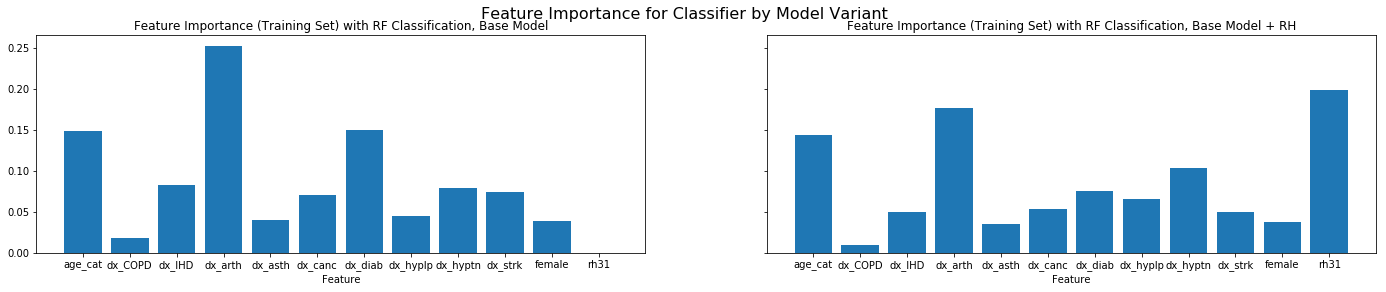

In [224]:
# Graph Feature Importance for both Full Models

# Graph Feature Importance for Regression Full Model
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,4), sharey=True, sharex=True)
plt.suptitle('Feature Importance for Classifier by Model Variant', fontsize=16)

ax1.bar((feat_var_clf_df['age_sex_dx'].variant), (feat_var_clf_df['age_sex_dx'].feature_imp))
ax1.set_title('Feature Importance (Training Set) with RF Classification, Base Model')
ax1.set_xlabel('Feature')

# Graph Feature Importance for Classification Full Model
ax2.bar((feat_var_clf_df['age_sex_dx_rh'].variant), (feat_var_clf_df['age_sex_dx_rh'].feature_imp))
ax2.set_title('Feature Importance (Training Set) with RF Classification, Base Model + RH')
ax2.set_xlabel('Feature')

### Quantile Analysis

In [225]:
# Create DataFrame with Predicted Values
pred_vals_clf_df = pd.DataFrame(tca)[['age_sex_dx', 'age_sex_dx_rh']].loc[['predicted_test']]
pred_vals_clf_df

,age_sex_dx,age_sex_dx_rh
predicted_test,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


In [226]:
# Distribution of breakdown of who we predict to be in the top 10% of costs vs who is actually in the top 10% of costs
# Breakdown people who we expect to be in the top 10% of costs for each model
# People from base model
base_top_10_test = test_df[pred_vals_clf_df['age_sex_dx'].iloc[0]]
print len(base_top_10_test)
# People from base + RH model
base_rh_top_10_test = test_df[pred_vals_clf_df['age_sex_dx_rh'].iloc[0]]
print len(base_rh_top_10_test)
# Actual top 10 from test set
real_top_10_test = test_df[top_percentile_subset_calculator(test_df.tot_exp, full_top_10_s, full_top_10_e)]
print len(real_top_10_test)
top_10_num_by_model = {'base': len(base_top_10_test), 'base_rh': len(base_rh_top_10_test), 'full': len(real_top_10_test)}

100
131
670


(Text(0,0.5,u'Number of People in top 10%'), Text(0.5,0,u'Model Variant'))

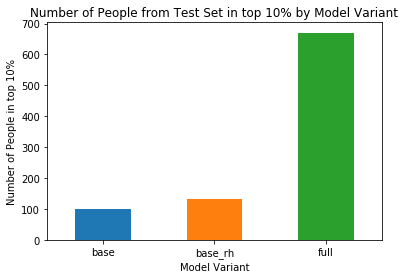

In [227]:
# Number of People predicted to be in the top 10% by model variant
pd.Series(top_10_num_by_model).plot.bar(title='Number of People from Test Set in top 10% by Model Variant', rot=0)

ax=plt.gca()
ax.set_ylabel('Number of People in top 10%'), ax.set_xlabel('Model Variant')

((-1.109957506613376,
  1.1004741669815894,
  -1.1092647851430253,
  1.1232054202182142),
 Text(0.5,1,u'True Distribution of top 10% - Full Dataset'),
 Text(0,0.5,u''))

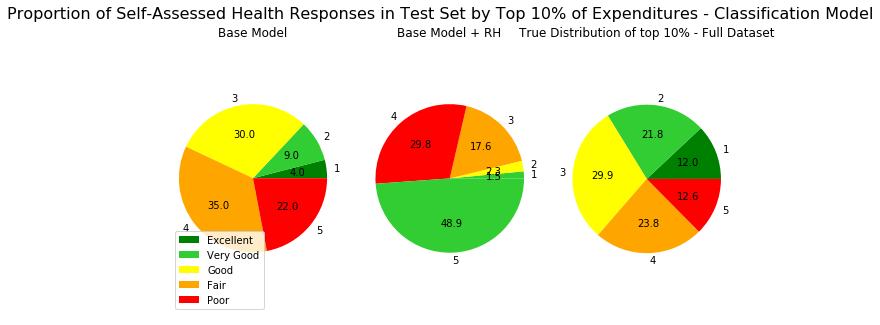

In [228]:
# Breakdown of Self-reported health by top 10 percent
fig, axs = plt.subplots(1, 3, figsize=(10,5))

plt.suptitle('Proportion of Self-Assessed Health Responses in Test Set by Top 10% of Expenditures - Classification Model', fontsize=16)

colors=['green','limegreen','yellow','orange','red']


base_top_10_test.rh31.value_counts().sort_index().plot.pie(colors=colors, autopct='%.1f', ax=axs[0], legend=True)
axs[0].axis('equal'), axs[0].set_title('Base Model'), axs[0].set_ylabel('')
axs[0].legend(loc=3, labels=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])

base_rh_top_10_test.rh31.value_counts().sort_index().plot.pie(colors=['limegreen','yellow', 'orange', 'red'], autopct='%.1f', ax=axs[1])
axs[1].axis('equal'), axs[1].set_title('Base Model + RH'), axs[1].set_ylabel('')

df[top_percentile_subset_calculator(df.tot_exp,full_top_10_s, full_top_10_e)].rh31.value_counts().sort_index().plot.pie(colors=colors, autopct='%.1f', ax=axs[2])
axs[2].axis('equal'), axs[2].set_title('True Distribution of top 10% - Full Dataset'), axs[2].set_ylabel('')

((-1.109957506613376,
  1.1004741669815894,
  -1.1092647851430253,
  1.1232054202182142),
 Text(0.5,1,u'True Distribution of top 10% - Full Dataset'),
 Text(0,0.5,u''))

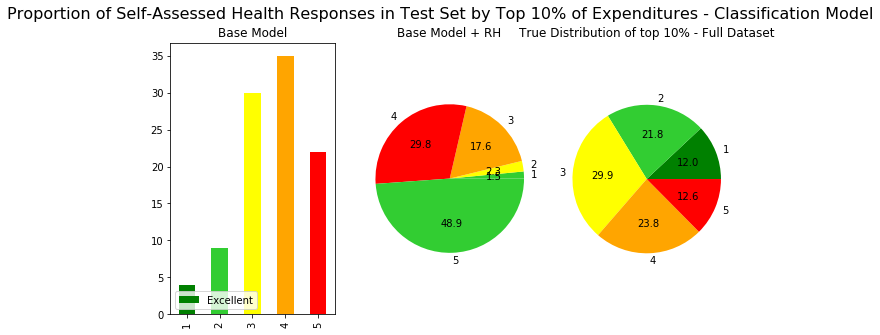

In [253]:



# Breakdown of Self-reported health by top 10 percent
fig, axs = plt.subplots(1, 3, figsize=(10,5))

plt.suptitle('Proportion of Self-Assessed Health Responses in Test Set by Top 10% of Expenditures - Classification Model', fontsize=16)

colors=['green','limegreen','yellow','orange','red']


base_top_10_test.rh31.transpose().value_counts().sort_index().plot.bar(colors=colors, stacked=True, ax=axs[0], legend=True)
axs[0].set_title('Base Model'), axs[0].set_ylabel('')
axs[0].legend(loc=3, labels=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])

base_rh_top_10_test.rh31.value_counts().sort_index().plot.pie(colors=['limegreen','yellow', 'orange', 'red'], autopct='%.1f', ax=axs[1])
axs[1].axis('equal'), axs[1].set_title('Base Model + RH'), axs[1].set_ylabel('')

df[top_percentile_subset_calculator(df.tot_exp,full_top_10_s, full_top_10_e)].rh31.value_counts().sort_index().plot.pie(colors=colors, autopct='%.1f', ax=axs[2])
axs[2].axis('equal'), axs[2].set_title('True Distribution of top 10% - Full Dataset'), axs[2].set_ylabel('')

In [229]:
def has_diag(row):
    return (row=='Yes').any()

In [230]:
# Breakdown of Diagnosis Categories by top 10 percent
from __future__ import division

top_10_dx_distrib = {}
for dx in chron_dx_categs:
    #print dx
    top_10_dx_distrib['{}'.format(dx)] = {}
    top_10_dx_distrib.get('{}'.format(dx))['base'] = ((len(base_top_10_test[base_top_10_test['{}'.format(dx)]]))/len(base_top_10_test))
    top_10_dx_distrib.get('{}'.format(dx))['base_rh'] = ((len(base_rh_top_10_test[base_rh_top_10_test['{}'.format(dx)]]))/len(base_rh_top_10_test))
    top_10_dx_distrib.get('{}'.format(dx))['full'] = ((len(real_top_10_test[real_top_10_test['{}'.format(dx)]]))/len(real_top_10_test))
    

In [231]:
top_10_dx_distrib

{'dx_COPD': {'base': 0.24,
  'base_rh': 0.2366412213740458,
  'full': 0.07014925373134329},
 'dx_IHD': {'base': 0.58,
  'base_rh': 0.5038167938931297,
  'full': 0.1373134328358209},
 'dx_arth': {'base': 0.99,
  'base_rh': 0.9541984732824428,
  'full': 0.4925373134328358},
 'dx_asth': {'base': 0.43,
  'base_rh': 0.37404580152671757,
  'full': 0.1761194029850746},
 'dx_canc': {'base': 0.47,
  'base_rh': 0.4198473282442748,
  'full': 0.20597014925373133},
 'dx_diab': {'base': 0.76,
  'base_rh': 0.6870229007633588,
  'full': 0.26119402985074625},
 'dx_hyplp': {'base': 0.9,
  'base_rh': 0.8625954198473282,
  'full': 0.48059701492537316},
 'dx_hyptn': {'base': 0.89,
  'base_rh': 0.916030534351145,
  'full': 0.5402985074626866},
 'dx_strk': {'base': 0.43,
  'base_rh': 0.32061068702290074,
  'full': 0.11492537313432835}}

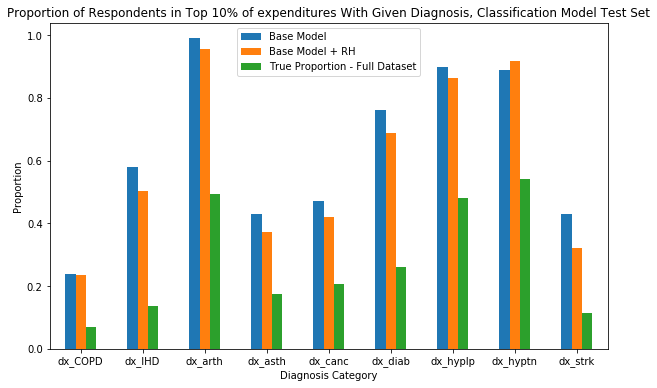

In [241]:
pd.DataFrame(top_10_dx_distrib).transpose().rename(index={'full' : 'True Values - Full Population'}).plot.bar(figsize=(10,6), rot=0, title='Proportion of Respondents in Top 10% of expenditures With Given Diagnosis, Classification Model Test Set')

ax=plt.gca()
ax.set_xlabel('Diagnosis Category'), ax.set_ylabel('Proportion')
ax.legend(['Base Model', 'Base Model + RH', 'True Proportion - Full Dataset'])